# Final Project - Road Detection
### 	Bruno Gazoni 7585037<br> 	Matheus Steigenberg Populim 10734710<br> Rafael Ceneme 	9898610<br> 	Bruno Baldissera  10724351

In [1]:
!pip install scikit-image

In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# The main objective of the project 
 The objective of this project is to identify and segment roads in aerial images of city areas.

# The description of input images (with examples) including the source of the images --- website, paper, acquired by the student(s)
The input images have been taken from the following Kaggle dataset: https://www.kaggle.com/deeenizka/road-segmentation

According to the uploader, the images are “[s]atellite images of Toronto which [he] used for road segmentation, every image is a square 1500x1500 pixels.” We will select some images with particular contrast between grassy and road areas to narrow down the scope of our project into something manageable.

Description of steps to reach the objective, including the methods that are intented to be used (e.g., image enhancement, edge-detection, morphology segmentation, texture analysis, color analysis, keypoint detection etc.). (2 pts)

## Reading the input image

In [3]:
name1 = "img10.png"
A = imageio.imread(name1)
print(A.shape)

(1500, 1500, 3)


# Plotting input image

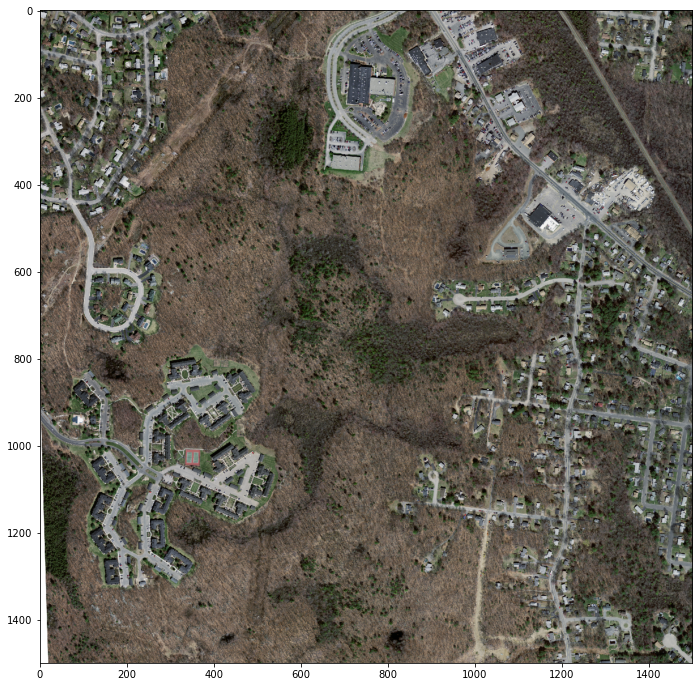

In [4]:
# plotting parameters adjustment
plt.rcParams["figure.figsize"] = (16,12)
plt.imshow(A)

## We now declare the useful normalization, gamma correction and average filtering functions

In [5]:
#função de normalização
def normalize(A, x):
    a = A.min()
    b = A.max()
    A = ((A-a)/(b-a))*x
    return A

In [6]:
#função para correção gamma
def gamma_correction(A,gamma):
    B = np.zeros((A.shape))
    B = 255*(np.power(A/255.0,1.0/gamma))
    B = normalize(B, 255)
    return B

In [7]:
#função para obter filtro de média
def get_average_filter(A):
    N = A.shape[0]
    n = 100
    C = np.zeros((N//n,N//n),dtype=np.float32)

    for i in range(N//n):
        for j in range(N//n):
            C[i,j] = np.average(A[i*n:(i+1)*n,j*n:(j+1)*n])

    C = np.kron(C,np.ones((n,n)))
    return C

## On our first test we apply the average filter in the image, normalize its values to the interval $[0,1]$ and apply the gamma correction.

In [8]:
# Converte para o sistema de cores HSV
img_hsv = mpl.colors.rgb_to_hsv(A)

# Inverte o valor S da imagem (queremos maximizar a baixa saturação)
teste = 1-img_hsv[:,:,1]

media = get_average_filter(teste)

teste = normalize(teste-media, 1)

teste_gamma = gamma_correction(teste, 0.8)

Text(0.5, 1.0, 'Average filter + gamma correction')

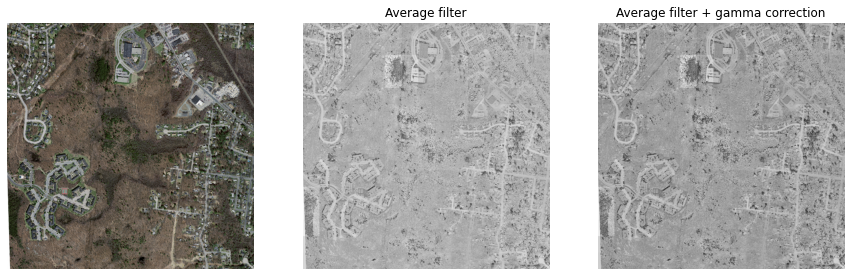

In [9]:
plt.figure(figsize=(15,15))
plt.subplot(131); plt.imshow(A, cmap="gray"); plt.axis('off')
plt.subplot(132); plt.imshow(teste, cmap="gray"); plt.axis('off'); plt.title('Average filter')
plt.subplot(133); plt.imshow(teste_gamma, cmap="gray"); plt.axis('off'); plt.title('Average filter + gamma correction')

# Saturation and value histogram analysis
In this step, we split the image into several tiles, then we create histograms for the saturation and values for each tile. Finally, we superpose all histograms on a plotted chart in order to try and find patterns and outliers.

157	156	157	157	156	157	
157	155	155	156	156	156	
158	155	156	157	159	154	
156	156	157	155	158	155	
158	155	156	157	158	155	
156	156	156	156	157	156	
172.26938480095868


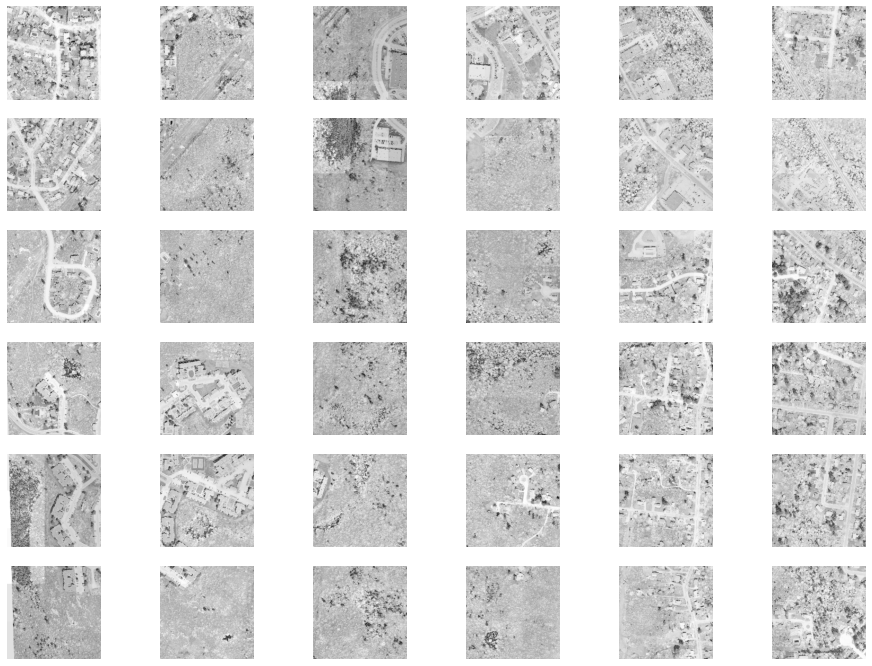







172.26938480095868


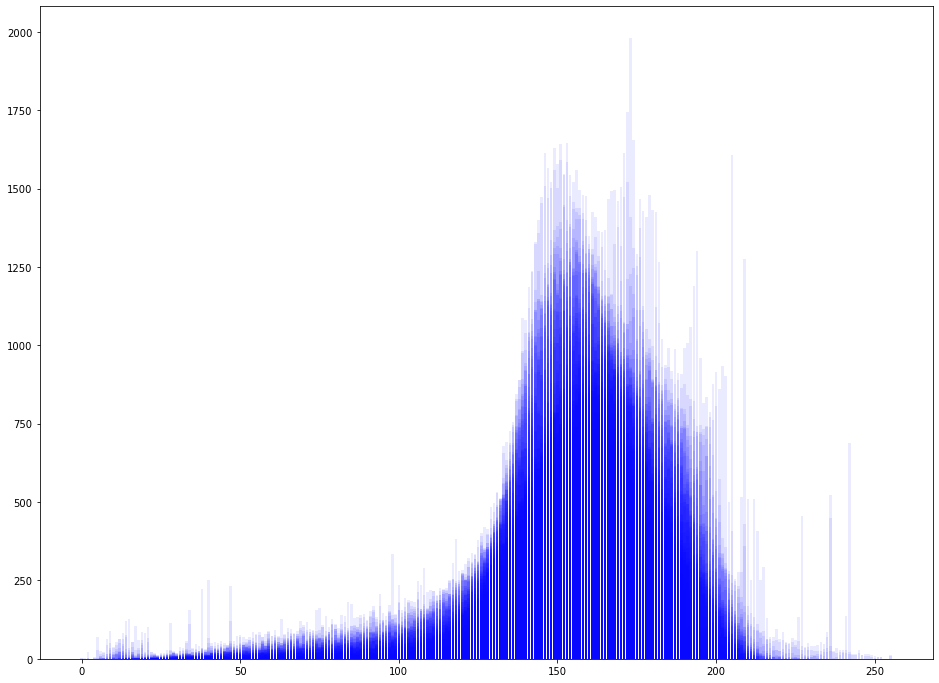

98	91	97	115	89	87	
103	92	89	101	110	93	
112	102	77	93	103	90	
98	106	84	78	98	90	
95	104	90	99	106	89	
105	109	90	105	115	85	
172.26938480095868


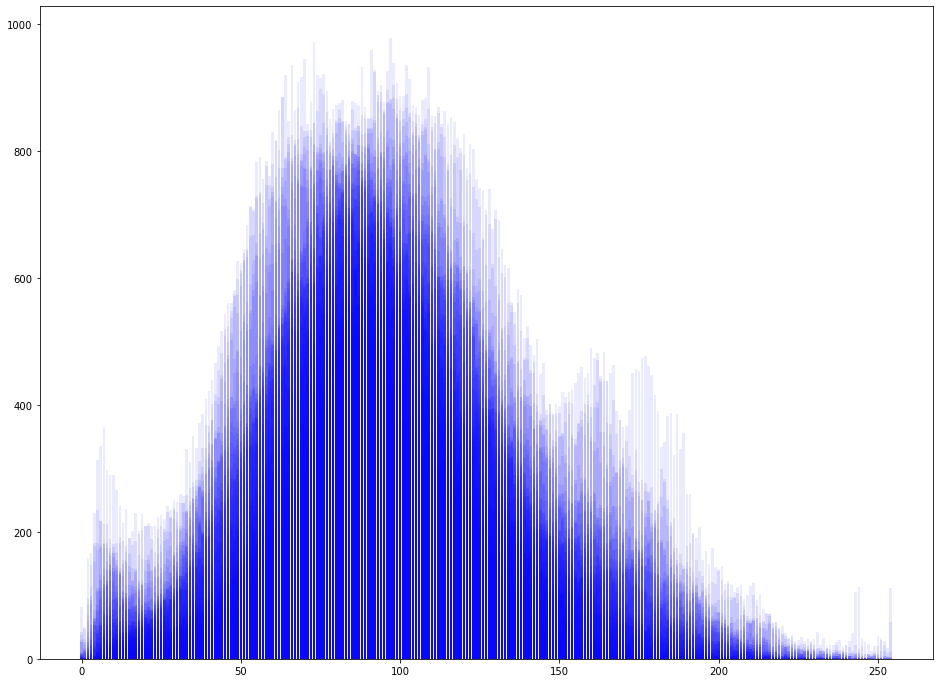

In [10]:
def histogram(A, no_levels):
    # gets the size of the input matrix
    N, M = A.shape
    # creates an empty histogram with size proportional to the number of graylevels 
    hist = np.zeros(no_levels).astype(int)

    # computes for all levels in the range
    for i in range(no_levels):
        # sum all positions in which A == i is true
        pixels_value_i = np.sum(A == i)
        # store it in the histogram array
        hist[i] = pixels_value_i
            
    return(hist)

valor = img_hsv[:,:,2]

# splits the image into several tiles
D = 6
side = teste.shape[0]//D
plt.figure()
plt.axis('off')
for i in range(D):
    for j in range(D):
        plt.subplot(D,D,i*D+j+1);
        plt.axis('off')
        plt.imshow(teste[i*side:(i+1)*side,j*side:(j+1)*side],cmap='gray');
        print(int(np.mean(teste_gamma[i*side:(i+1)*side,j*side:(j+1)*side])),end='\t')
    print()
print(np.mean(teste)*255)
plt.show()

# plots saturation histograms
plt.figure()
for i in range(D):
    for j in range(D):
        hist_B = histogram(teste_gamma[i*side:(i+1)*side,j*side:(j+1)*side].astype(np.uint8), 256)
        plt.bar(range(256), hist_B,fc=(0, 0, 1, 0.08))
    print()
print(np.mean(teste)*255)
plt.show()

# plots value histograms
plt.figure()
for i in range(D):
    for j in range(D):
        print(int(np.mean(valor[i*side:(i+1)*side,j*side:(j+1)*side])),end='\t')
        hist_B = histogram(valor[i*side:(i+1)*side,j*side:(j+1)*side].astype(np.uint8), 256)
        plt.bar(range(255), hist_B[:255],fc=(0, 0, 1, 0.08))
    print()
print(np.mean(teste)*255)
plt.show()

# Image Thresholding

We now perform thresholding on the image obtained after earlier processing to select the candidate road pixels.

Our thresholding method additionally uses the V value on the HSV system, such that only pixels with V value in $[L_1, L_2]$ are chosen. The boundaries defined by $L_1$ and $L_2$ were determined by analising the value histograms above.

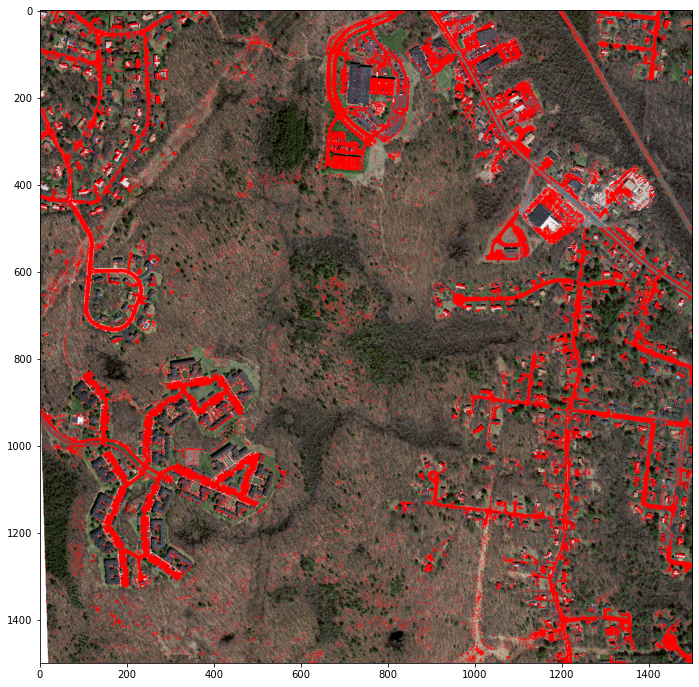

In [11]:
# Colocamos na variável 'valor' os valores V da imagem
valor = img_hsv[:,:,2]

f_tr = np.ones(teste.shape).astype(np.uint8)
# setting to 0 the pixels below the threshold
# f_tr = A[:,:,0]

# Adicionamos a restrição do valor V estar no intervalo [L1, L2]
L1 = 200
L2 = 110

B = np.copy(A)
B[(np.where((teste_gamma > 170) & (teste_gamma < 255) & (valor < L1) & (valor > L2)))] = [255,0,0]

plt.imshow(B)
plt.show()

# Otsu Thresholding Method

 In the search of new methods we start with the Otsu threshold method, which uses the histogram of the image, and achieves an interesting, noticeably better result than the one obtained using just the mean intensity threshold.

In [12]:
def thresholding(f, L):
    # create a new image with ones
    f_tr = np.ones(f.shape).astype(np.uint8)
    # setting to 0 the pixels below the threshold
    f_tr[np.where(f < L)] = 0
    return f_tr

In [13]:
def otsu_threshold(img, max_L):
    M = np.product(img.shape)
    min_var = []
    hist_t,_ = np.histogram(img, bins=256, range=(0,256))
    
    img_t = thresholding(img, 0)
    
    for L in np.arange(1, max_L):
        img_ti = thresholding(img, L)
        # computing weights
        w_a = np.sum(hist_t[:L])/float(M)
        w_b = np.sum(hist_t[L:])/float(M)
        # computing variances
        sig_a = np.var(img[np.where(img_ti == 0)])
        sig_b = np.var(img[np.where(img_ti == 1)])
        
        min_var = min_var + [w_a*sig_a + w_b*sig_b]
        
    img_t = thresholding(img, np.argmin(min_var))
    
    return img_t, np.argmin(min_var)

Text(0.5, 1.0, 'Otsu threshold (165)')

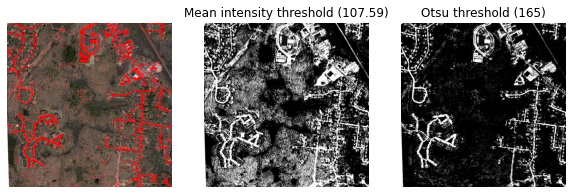

In [14]:
img_o, OL = otsu_threshold(B[:,:,0], 255)
hist_o,_ = np.histogram(img_o*255, bins=256, range=(0,256))

mean_v = np.mean(B[:,:,0])

img_t = thresholding(B[:,:,0], mean_v)

plt.figure(figsize=(10,15))
plt.subplot(131); plt.imshow(B,cmap="gray"); plt.axis('off')
plt.subplot(132); plt.imshow(img_t, cmap="gray"); plt.axis('off'); plt.title('Mean intensity threshold (%.2f)' % (mean_v))
plt.subplot(133); plt.imshow(img_o, cmap="gray"); plt.axis('off'); plt.title('Otsu threshold (%d)' % (OL))

In [15]:
image = gamma_correction(img_o, 0.8)

# Hough Transform

We now try to apply the Hough transformation on our image, using the line shape as parameter, as it is geometrically close to road segments.

 But first we use the Canny border detection method in order to highlight the road border regions and enhance the performance of the Hough transform (its standalone effect is exhibited in the middle image).

In [16]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line

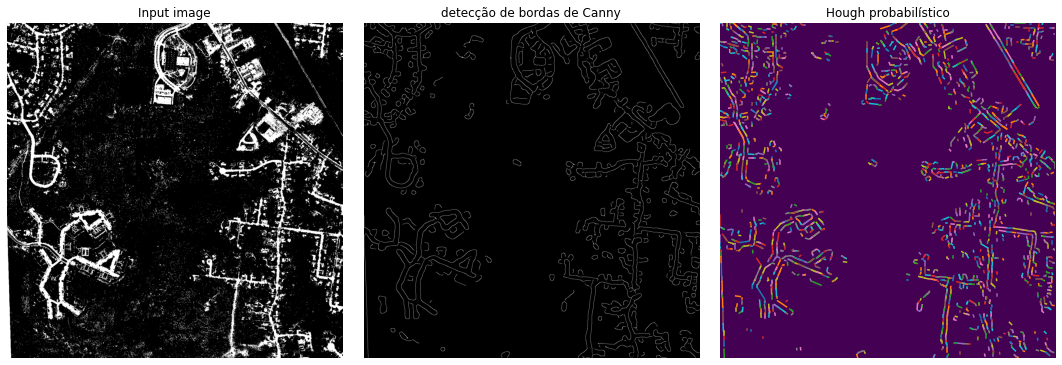

In [17]:
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform
edges = canny(image, 8, 1, 25)
lines = probabilistic_hough_line(edges, threshold=45, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=mpl.cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=mpl.cm.gray)
ax[1].set_title('detecção de bordas de Canny')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Hough probabilístico')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Region Growing

Our next trial method is based on region growing using an iterative implementation of a floodfill method (because of the size of the images, a recursive implementation requires huge ammounts of memory to store all function calls) using a tolerance value to serve as borders. 

In [18]:
def distance(a, b):
    return np.abs(a-b)

def is_zero(grid, row, col):
        # Helper method for checking whether the pixel belongs to an island or not
        if (row < 0 or row > len(grid) - 1):
            return False

        if (col < 0 or col > len(grid[0]) - 1):
            return False

        if grid[row][col] == 0:
            return True
        else:
            return False

def region_growing_average(img, img_t, tolerance, seed, sx, sy):
    #img_t = np.zeros(img.shape)
    x = seed[0]; y = seed[1]

    grid = np.zeros((sx, sy))
    grid[x,y] = -1
    q = []  # init empty queue (FIFO)
    q.append([x,y])  # add to queue

    while len(q) > 0:
        [cur_x, cur_y] = q[0]
        del q[0]

        avg = np.mean(img[np.where(img_t==1)])

        img_t[cur_x, cur_y] = 1

        if (is_zero(grid, cur_x-1, cur_y) == True and distance(avg, img[cur_x-1,cur_y]) <= tolerance):
            grid[cur_x-1][cur_y] = -1
            q.append([cur_x-1, cur_y])

        if (is_zero(grid, cur_x+1, cur_y) == True and distance(avg, img[cur_x+1,cur_y]) <= tolerance):
            grid[cur_x+1][cur_y] = -1
            q.append([cur_x+1, cur_y])

        if (is_zero(grid, cur_x, cur_y-1) == True and distance(avg, img[cur_x,cur_y-1]) <= tolerance):
            grid[cur_x][cur_y-1] = -1
            q.append([cur_x, cur_y-1])

        if (is_zero(grid, cur_x, cur_y+1) == True and distance(avg, img[cur_x,cur_y+1]) <= tolerance):
            grid[cur_x][cur_y+1] = -1
            q.append([cur_x, cur_y+1])

    return img_t

###  We iteratively apply region growing to the image with randomly selected pixels as starting points, where the sample space is restricted to pixels which were previously selected as road pixels with the thresholding method.

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  

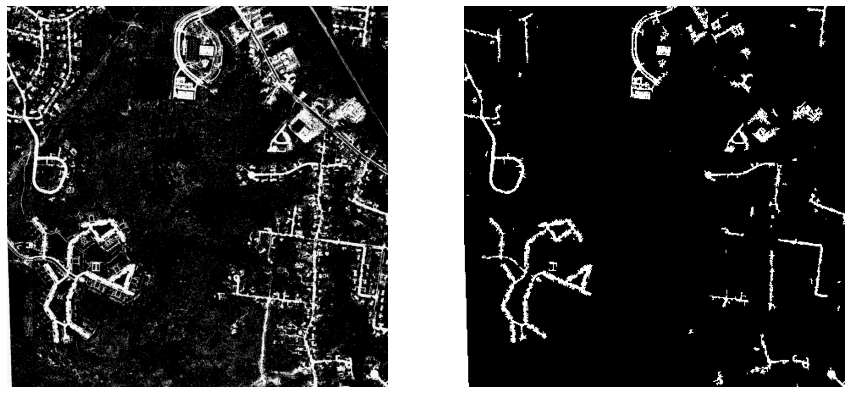

In [19]:
from skimage.transform import rescale

#gera a matriz output do floodfill
#escolhemos a seed aleatoriamente entre os pixels da imagem e cobrimos toda a imagem
#n vezes

# realça as arestas da imagem encontradas pelo método Canny somando-as à imagem com peso w
w = 10
image += w*edges

# escala a imagem para tornar mais rápida a execução da célula
scale = 0.3
image_rescaled = rescale(image, scale, anti_aliasing=False)
img_seed = np.zeros(image_rescaled.shape)

img_o_rescaled = rescale(img_o*255, scale, anti_aliasing=False)
img_o_rescaled = img_o_rescaled.astype(np.int32)

sx = image_rescaled.shape[0]
sy = image_rescaled.shape[1]

ones = []
for i in range(sx):
    for j in range(sy):
        if img_o_rescaled[i,j] == 1:
            ones.append((i, j))

# realiza region growing em n iterações, a cada iteração escolhendo seeds aleatórias dentre os
#  pixels realçados pelos métodos anteriores
n = 150
x = int(sx/2)
y = int(sy/2)
for i in range(n):
    sel = np.random.randint(0, len(ones))
    x, y = ones[sel]
    del ones[sel]
    img_seed = region_growing_average(image_rescaled, img_seed, 20, [x,y], sx, sy)
    print(i, " ", end="")

plt.figure(figsize=(15,15))
plt.subplot(121); plt.imshow(image,cmap="gray"); plt.axis('off')
plt.subplot(122); plt.imshow(img_seed*255, cmap="gray"); plt.axis('off');

## Region Growing Results & Discussion
Our region growing attempt was not able to efficiently find a large ammount of road segments, even though it had promising attempts. In order to perform region growing on a satisfying number of segments and perform better than our previous attempts we would have to iterate the method so many times that it would be inviable computationally.

The image below was obtained by running the Region Growing algorithm with $n = 1000$, in a separate notebook: 

<img src="n1000.jpeg">

# Bonus section
For this image, we played around with the results of the Otsu thresholding: we selected all the pixels where the algorithm didn't expect roads and colored them white. Curiously, the result was a snowy landscape generator for aerial photographs.

<img src="snowy.jpeg">

# References
Nachmany, Yoni & Alemohammad, Hamed. (2019). Detecting Roads from Satellite Imagery in the Developing World.

https://github.com/maponti/imageprocessing_course_icmc

https://repository.tudelft.nl/islandora/object/uuid:21fc20a8-455d-4583-9698-4fea04516f03/datastream/OBJ2/download

https://www.cs.toronto.edu/~hinton/absps/road_detection.pdf

https://www.sciencedirect.com/science/article/abs/pii/S0303243406000171